1) Given a single note return TF-IDF score for top words.
2) I plan to integrate these top scores into the vault_index.json and produce an enhanced_vault_index.json file.
3) Using the scores within the enhanced_vault_index.json possiblely cluster or classify the documents afterward?

### 1) Given a single note return TF-IDF score for top words.


In [1]:
from pathlib import Path
import re
from markdown import markdown
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [2]:
def normalize_document(doc):
    tokens = tokenizer.tokenize(doc.lower())
    return [
        lemmatizer.lemmatize(t)
        for t in tokens if t not in stop_words and len(t) > 2
    ]

def strip_yaml(text):
    """Remove YAML front matter from a Markdown document."""
    return re.sub(r"^---.*?---\s*", "", text, flags=re.DOTALL)

def read_markdown_file(path):
    with open(path, encoding="utf-8") as f:
        text = f.read()
        text = strip_yaml(text)
        html = markdown(text)
        soup = BeautifulSoup(html, features="html.parser")
        return soup.get_text()

In [48]:
# === CONFIGURATION ===
filename = "Views.md"
VAULT_PATH = Path("C:/Users/RhysL/Desktop/Data-Archive/content/standardised")
file_path = VAULT_PATH / filename

# === TEXT PREPROCESSING ===
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')


In [49]:
# === MAIN TF-IDF PIPELINE ===
document = read_markdown_file(file_path)
corpus = [document]  # Single-document corpus

vectorizer = CountVectorizer(tokenizer=normalize_document)
X_counts = vectorizer.fit_transform(corpus)

tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_counts)

# === OUTPUT RESULTS ===
feature_names = vectorizer.get_feature_names_out()
scores = X_tfidf[0].T.toarray().flatten()
terms_scores = [(feature_names[i], score) for i, score in enumerate(scores) if score > 0]
sorted_terms = sorted(terms_scores, key=lambda x: -x[1])

c:\Users\RhysL\Desktop\Data-Archive-Graph\venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [50]:
print(f"\nTop TF-IDF Terms in {filename}:")
for term, score in sorted_terms[:10]:  # Top 20 terms
    print(f"{term:>15}: {score:.4f}")


Top TF-IDF Terms in Views.md:
           view: 0.5551
           data: 0.4362
          table: 0.1983
         access: 0.1586
          query: 0.1586
           user: 0.1586
        complex: 0.1190
       database: 0.1190
    performance: 0.1190
         result: 0.1190


### 2) Integrate these top scores into the vault_index.json and produce an enhanced_vault_index.json file.

Batch Processing with TF-IDF Integration


Loads vault_index.json first to identify which .md files to process.

Reads only the corresponding Markdown files from disk (not the entire folder).

Extracts main content (excluding YAML).

Computes top 10 TF-IDF scores per file.

Inserts these scores as a new key "TFIDF_Score" in the vault_index object.

Writes an enhanced version to enhanced_vault_index.json.

The titles in vault_index.json are the titles/aliases "What is Apache Airflow?" from metadata and not the title from the file. 

This is an issue with build_vault_index.ipynb.

In [ ]:
Prompt:

### 2) Integrate the top 10 scores into the vault_index.json and produce an enhanced_vault_index.json file.

In the file vault_index.json Which is of the form:

{
  "1-on-1_template": {
    "title": "1-on-1 Template",
    "tags": [],
    "aliases": [],
    "outlinks": [],
    "inlinks": [
      "documentation_&_meetings"
    ],
    "summary": "Decisions [Your name] add decisions that need to be made [Other person's name] add decisions that need to be made Action items [Your name] add..."
  },similar keys...}

# Where the key is the filename (just like how we did for View.md) and the value is a dictionary of the title, tags, aliases, outlinks, inlinks and summary.
# When we go to add these top score we should add a new key to this dictionary called TFIDF_Score where the value will be the 
# top 10 scores as a dict. The key will be the term and the value will be the score.



In [3]:
import json
import re
from pathlib import Path
from markdown import markdown
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [5]:
# === CONFIGURATION ===
VAULT_PATH = Path("C:/Users/RhysL/Desktop/Data-Archive/content/standardised")
MD_FILES = list(VAULT_PATH.glob("*.md"))
JSON_PATH = "vault_index.json"
OUTPUT_PATH = "enhanced_vault_index.json"

# === TEXT PREPROCESSING ===
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

In [6]:
# === STEP 1: READ ALL DOCUMENTS ===
corpus = []
filenames = []

for md_file in MD_FILES:
    text = read_markdown_file(md_file)
    corpus.append(text)
    filenames.append(md_file.stem)  # filename without ".md"

# === STEP 2: COMPUTE TF-IDF ===
vectorizer = CountVectorizer(tokenizer=normalize_document)
X_counts = vectorizer.fit_transform(corpus)
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_counts)

c:\Users\RhysL\Desktop\Data-Archive-Graph\venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [7]:
# === STEP 3: LOAD vault_index.json ===
with open(JSON_PATH, "r", encoding="utf-8") as f:
    vault_index = json.load(f)

def normalize_title(title):
    """
    Normalize title by converting to lowercase and replacing spaces with underscores.
    """
    return title.lower().replace(" ", "_")

# apply normalize_title to all terms in filenames
normalized_filenames = [normalize_title(filename) for filename in filenames]

# normalized_filenames and vault_index_l are the same

# === STEP 4: ADD TF-IDF SCORES ===
vault_index_l=list(vault_index.keys())
feature_names = vectorizer.get_feature_names_out()
skipped = 0
for i, filename in enumerate(normalized_filenames):
    if filename not in vault_index_l:
        # print(f"Skipping: {filename} not in vault_index.json")
        skipped+=1
        continue

    scores = X_tfidf[i].T.toarray().flatten()
    terms_scores = [(feature_names[j], float(scores[j])) for j in range(len(scores)) if scores[j] > 0]
    top_10_scores = dict(sorted(terms_scores, key=lambda x: -x[1])[:10])

    vault_index[filename]["TFIDF_Score"] = top_10_scores

print("number of terms skipped", skipped)


number of terms skipped 0


In [ ]:
#CHECK:
# normalized_filenames[:10]
# # list(vault_index.keys())==normalized_filenames

# vault_filenames = list(vault_index.keys())

# # show those that are different
# l=[]
# for i in range(len(vault_filenames)):
#     if vault_filenames[i] != normalized_filenames[i]:
#         # print(f"{vault_filenames[i]} != {normalized_filenames[i]}")
#         l.append((vault_filenames[i], normalized_filenames[i]))
# len(l)


# vault_index_l=list(vault_index.keys())
# len(vault_index_l)
# vault_index_l[:10]

# filenames[:10]

# Only 27 terms have TFIDF_Score, see dagster

0

In [8]:
# === STEP 5: SAVE TO enhanced_vault_index.json ===
with open(OUTPUT_PATH, "w", encoding="utf-8") as f:
    json.dump(vault_index, f, indent=2, ensure_ascii=False)

print(f"Enhanced vault index written to: {OUTPUT_PATH}")


Enhanced vault index written to: enhanced_vault_index.json


### 3) Using the scores within the enhanced_vault_index.json possiblely cluster or classify the documents afterward?

In [ ]:
import json
import numpy as np

In [ ]:
# === STEP 1: Load the enhanced vault_index.json ===
with open("enhanced_vault_index.json", "r", encoding="utf-8") as f:
    vault_index = json.load(f)

# === STEP 2: Convert TF-IDF Scores into a Feature Matrix ===
# Create a list of document titles (for labeling purposes)
titles = list(vault_index.keys())

# Create a matrix where each row is a document and each column is a term's score
# We'll use a dictionary to keep track of all unique terms in the entire corpus
all_terms = set()

# Collect all unique terms from the TFIDF_Score of all documents
for doc in vault_index.values():
    all_terms.update(doc['TFIDF_Score'].keys())

# Create a mapping of terms to index in the feature matrix
term_to_index = {term: idx for idx, term in enumerate(all_terms)}

# Now, create the feature matrix
num_documents = len(vault_index)
num_terms = len(all_terms)
X = np.zeros((num_documents, num_terms))

# Populate the feature matrix with TF-IDF scores
for i, doc in enumerate(vault_index.values()):
    for term, score in doc['TFIDF_Score'].items():
        term_idx = term_to_index[term]
        X[i, term_idx] = score
        # print(term, score)

# get the value of a specific term for a specific document

In [ ]:
#TEST
# list(all_terms)[0] = 'exceptionally
# === STEP 3: Verify if X is not full of zeros ===
# Check if 'exceptionally' is in the term set
if 'exceptionally' in term_to_index:
    term_idx = term_to_index['exceptionally']
    # Print the values for the specific term across all documents
    print("Values for 'exceptionally' across documents:")
    print(X[:, term_idx])  # All documents' scores for the term 'exceptionally'
else:
    print("Term 'exceptionally' not found in the vocabulary.")

# Additionally, print a portion of the feature matrix to ensure it's populated
# print("\nSample of feature matrix X:")
# print(X[:5, :10])  # Display first 5 documents and first 10 terms

In [20]:
# Get the size of X (number of documents and number of terms)
size_X = X.shape

# Print the size of X
print("Size of X (documents, terms):", size_X)

Size of X (documents, terms): (796, 2880)


In [38]:
# get X as a dataframe
import pandas as pd

df = pd.DataFrame(X, columns=list(term_to_index.keys()))
df

,exceptionally,spam,advance,example,truth,accuracy,sequential,template,big_matrix,proposal,...,monolith,kpi,coordinate,better,minimize,prime,entering,basemodel,logistic,stacking
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.383729,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,0.0,0.0,0.0,0.0,0.0,0.117339,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
792,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
793,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
794,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Further explorations

This groups similar documents using Cosine Similarity and Hierarchical Clustering. The goal is to visualize the relationships between documents and determine the optimal number of clusters. The script performs the following tasks:

Cosine Similarity is computed between documents to understand their pairwise similarities.

Hierarchical Clustering is applied to the similarity matrix to create a dendrogram, which helps visualize how documents are clustered.

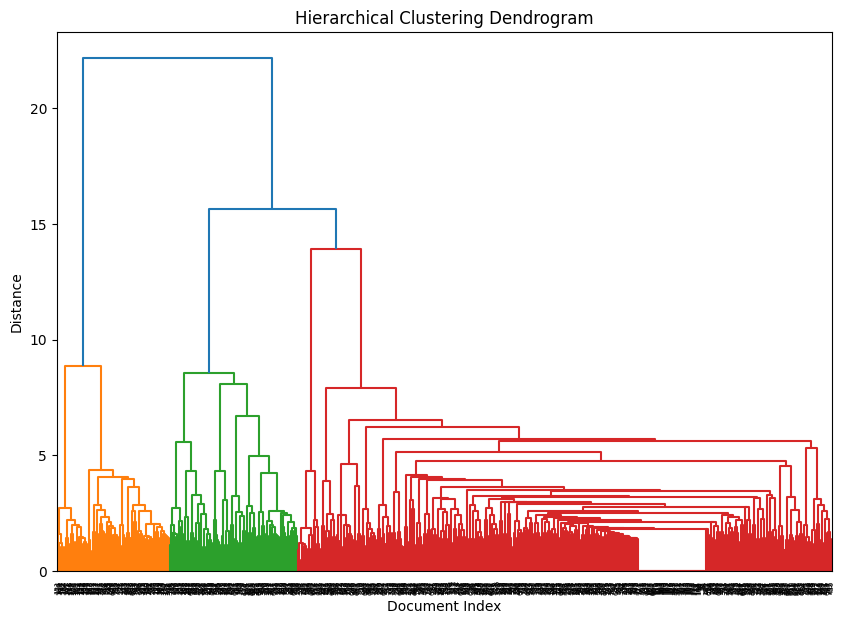

In [49]:
from sklearn.metrics.pairwise import cosine_similarity
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Step 1: Compute the Cosine Similarity Matrix
similarity_matrix = cosine_similarity(X)

# Step 2: Perform Hierarchical Clustering on the Cosine Similarity Matrix
linkage_matrix = sch.linkage(similarity_matrix, method='ward')

# Step 3: Visualize the Clusters using a Dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Document Index")
plt.ylabel("Distance")
plt.show()


Using the hierarchical clustering dendrogram. After visually inspecting the dendrogram, you can set a threshold distance to cut the tree and determine the number of clusters. The fcluster function is used to assign documents to clusters based on the threshold distance. The script then prints the number of clusters.

In [ ]:
from scipy.cluster.hierarchy import fcluster

# Step 1: Define the maximum distance for cutting the tree (threshold value).
# This threshold will determine the number of clusters by cutting the tree at the specified height.
max_distance = 4  # Adjust this value based on your dendrogram

# Step 2: Use fcluster to assign documents to clusters based on the linkage matrix and threshold
clusters = fcluster(linkage_matrix, max_distance, criterion='distance')

# Step 3: Print the number of unique clusters and their assignments
print(f"Number of clusters: {len(set(clusters))}")
# Optionally, you can print the cluster assignment for each document.
# print("Cluster assignments:", clusters)


Number of clusters: 29


#### Latent Dirichlet Allocation (LDA) (Explore further)

This code is performing topic modeling using the Latent Dirichlet Allocation (LDA) algorithm, a popular method for discovering hidden topics in a set of documents. Here’s a step-by-step breakdown of what’s happening:

1. Goal:
The objective of this code is to discover hidden topics within the documents, i.e., it tries to identify clusters of words that often appear together across the documents and group them into topics.

2. Latent Dirichlet Allocation (LDA):
LDA is a generative probabilistic model that assumes each document is a mixture of topics, and each topic is a distribution over words.

The LDA model tries to find a set of topics that best explain the observed documents in terms of word distribution.

In [48]:
# Goal: Discover hidden topics within the documents.
# Technique: Latent Dirichlet Allocation (LDA) or Non-negative Matrix Factorization 
# (NMF) are common methods for topic modeling.

from sklearn.decomposition import LatentDirichletAllocation

# Get the list of terms in the same order as the columns in the matrix X
index_to_term = {idx: term for term, idx in term_to_index.items()}

# Now, fit the LDA model to find topics
lda = LatentDirichletAllocation(n_components=20, random_state=42)
lda_topics = lda.fit_transform(X)

# Print top words for each topic
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    # Get the top 10 words for this topic
    top_terms_idx = topic.argsort()[:-11:-1]  # Get the indices of the top 10 words
    top_terms = [index_to_term[i] for i in top_terms_idx]
    print(top_terms)


Topic 0:
['word', 'memory', 'nosql', 'shorting', 'bash', 'gram', 'checksum', 'agent', 'scaling', 'amazon']
Topic 1:
['data', 'word', 'vector', 'token', 'pivot_table', 'grep', 'contract', 'management', 'pca_based_anomaly_detection', 'fact']
Topic 2:
['energy', 'model', 'data', 'feature', 'threshold', 'modelling', 'importance', 'file', 'ensemble', 'proportion']
Topic 3:
['momentum', 'gradient', 'venv', 'descent', 'bandit', 'model', 'map', 'view', 'procedure', 'wmts']
Topic 4:
['event', 'model', 'feature', 'component', 'pca', 'correlation', 'principal', 'data', 'coefficient', 'variable']
Topic 5:
['model', 'data', 'network', 'boosting', 'query', 'file', 'layer', 'forest', 'word', 'transaction']
Topic 6:
['loss', 'data', 'model', 'query', 'function', 'class', 'probability', 'service', 'cloud', 'de_tools']
Topic 7:
['data', 'attention', 'model', 'information', 'unstructured', 'format', 'error', 'head', 'dataframe', 'record']
Topic 8:
['data', 'sql', 'network', 'sigma', 'feature', 'variable'

#### Outliers

In [36]:
# Goal: Identify documents that are significantly different from the rest.

from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(contamination=0.1)
outliers = isolation_forest.fit_predict(X)

# print("Outlier labels: ", outliers)

# get docs of X that are outliers
outlier_docs = [titles[i] for i in range(len(outliers)) if outliers[i] == -1]
print("Number of outlier docs: ", len(outlier_docs))


Number of outlier docs:  80


#### Querying

In [ ]:
# 7. Document Ranking / Search Engine
# Goal: Rank documents based on relevance to a query.
# Technique: Use the cosine similarity between a query and documents to rank them, or compute a relevance score using TF-IDF.
from sklearn.metrics.pairwise import cosine_similarity

def search_documents(query, X, vault_index, term_to_index):
    # Preprocess the query in the same way as documents
    query_vector = np.zeros(X.shape[1])
    for word in query.split():
        if word in term_to_index:
            query_vector[term_to_index[word]] = 1  # Set to 1 or use actual TF-IDF if needed

    # Compute cosine similarity
    similarity = cosine_similarity([query_vector], X)

    # Sort by similarity
    sorted_indices = similarity.argsort()[0][::-1]
    for idx in sorted_indices[:5]:
        print(f"Document: {vault_index[titles[idx]]['title']}, Similarity: {similarity[0][idx]}")

query="querying"
search_documents(query, X, vault_index, term_to_index)


Document: Querying, Similarity: 0.5964916321941033
Document: SQL, Similarity: 0.2635833131269496
Document: Data Warehouse, Similarity: 0.21493648689430742
Document: Query Optimisation, Similarity: 0.2136463217748205
Document: Microsoft Access, Similarity: 0.21182979292629436


#### Word cloud

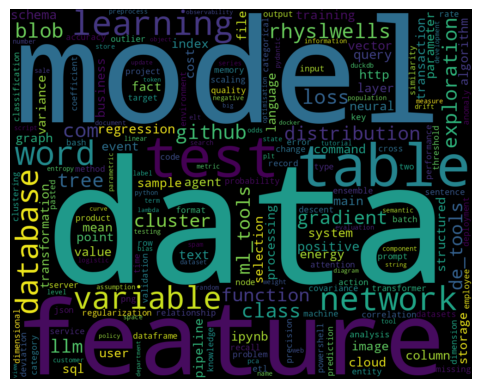

In [ ]:
# 5. Word Cloud / Term Frequency Visualization
# Goal: Visualize the most common terms across all documents.
# Technique: Create a word cloud from the TF-IDF scores to highlight important terms.

from wordcloud import WordCloud

# Aggregate all the TF-IDF scores
all_scores = {}
for doc in vault_index.values():
    for term, score in doc["TFIDF_Score"].items():
        all_scores[term] = all_scores.get(term, 0) + score

wordcloud = WordCloud(width=1000, height=800).generate_from_frequencies(all_scores)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# Others

In [23]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda_topics = lda.fit_transform(X)

# Print top words for each topic
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print([term_to_index[key] for key in topic.argsort()[:-10 - 1:-1]])  # top 10 words per topic


Topic 0:


KeyError: np.int64(1521)

In [25]:

# # === STEP 3: Apply Clustering (KMeans) ===
# # Standardizing the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Apply PCA for dimensionality reduction (optional, but useful for visualization)
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

# # Apply KMeans clustering
# kmeans = KMeans(n_clusters=9, random_state=42)  # Change n_clusters as needed
# kmeans.fit(X_scaled)

# # === STEP 4: Visualize the Clusters (optional) ===
# plt.figure(figsize=(8, 6))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
# plt.title("PCA of TF-IDF Feature Space (KMeans Clusters)")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.colorbar(label="Cluster Label")
# plt.show()

In [ ]:


# # Add cluster labels to the documents
# for i, title in enumerate(titles):
#     vault_index[title]["cluster_label"] = kmeans.labels_[i]

# # === STEP 5: Inspect Clustered Documents ===
# # Inspecting the documents based on their cluster labels
# clustered_docs = {}
# for title, doc in vault_index.items():
#     label = doc["cluster_label"]
#     if label not in clustered_docs:
#         clustered_docs[label] = []
#     clustered_docs[label].append(title)

# # Display cluster-wise documents
# for label, docs in clustered_docs.items():
#     print(f"Cluster {label}:")
#     for doc in docs:
#         print(f"  - {doc}")
